In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import open_clip
import matplotlib.pyplot as plt
from typing import List
import warnings

/home/uceepl4/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

In [16]:
# Configuration class
class Config:
    batch_size = 32
    learning_rate = 2e-5
    epochs = 20
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_name = "hf-hub:imageomics/bioclip"
    num_classes = 0
    image_size = 224
    top_k = 10

config = Config()

In [4]:

class FungiTastic(torch.utils.data.Dataset):
    """
    Dataset class for the FewShot subset of the Danish Fungi dataset (size 300, closed-set).

    This dataset loader supports training, validation, and testing splits, and provides
    convenient access to images, class IDs, and file paths. It also supports optional
    image transformations.
    """

    SPLIT2STR = {'train': 'Train', 'val': 'Val', 'test': 'Test'}

    def __init__(self, root: str, split: str = 'val', transform=None):
        """
        Initializes the FungiTastic dataset.

        Args:
            root (str): The root directory of the dataset.
            split (str, optional): The dataset split to use. Must be one of {'train', 'val', 'test'}.
                Defaults to 'val'.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        super().__init__()
        self.split = split
        self.transform = transform
        self.df = self._get_df(root, split)
        self.feature_df = self.df.copy()
        self.feature_selection = ['year', 'month', 'habitat', 'country_code', 'iucnRedListCategory', 'substrate', 'coorUncert', 'latitude', 'longitude', 'region', 'district', 'poisonous', 'elevation', 'landcover', 'biogeographicalRegion']

        assert "image_path" in self.df
        if self.split != 'test':
            assert "category_id" in self.df
            self.n_classes = len(self.df['category_id'].unique())
            self.category_id2label = {
                k: v[0] for k, v in self.df.groupby('category_id')['species'].unique().to_dict().items()
            }
            self.label2category_id = {
                v: k for k, v in self.category_id2label.items()
            }
        else:
            # For test set, we need to load category IDs from training set
            train_df = self._get_df(root, 'train')
            self.n_classes = len(train_df['category_id'].unique())
            self.category_id2label = {
                k: v[0] for k, v in train_df.groupby('category_id')['species'].unique().to_dict().items()
            }
            self.label2category_id = {
                v: k for k, v in self.category_id2label.items()
            }

    def add_embeddings(self, embeddings: pd.DataFrame):
        """
        Updates the dataset instance with new embeddings.

        Args:
            embeddings (pd.DataFrame): A DataFrame containing an 'embedding' column.
                                       It must align with `self.df` in terms of indexing.
        """
        assert isinstance(embeddings, pd.DataFrame), "Embeddings must be a pandas DataFrame."
        assert "embedding" in embeddings.columns, "Embeddings DataFrame must have an 'embedding' column."
        assert len(embeddings) == len(self.df), "Embeddings must match dataset length."

        self.df = pd.merge(self.df, embeddings, on="filename", how="inner")

    def get_embeddings_for_class(self, id):
        # return the embeddings for class class_idx
        class_idxs = self.df[self.df['category_id'] == id].index
        return self.df.iloc[class_idxs]['embedding']

    @staticmethod
    def _get_df(data_path: str, split: str) -> pd.DataFrame:
        """
        Loads the dataset metadata as a pandas DataFrame.

        Args:
            data_path (str): The root directory where the dataset is stored.
            split (str): The dataset split to load. Must be one of {'train', 'val', 'test'}.

        Returns:
            pd.DataFrame: A DataFrame containing metadata and file paths for the split.
        """
        df_path = os.path.join(
            data_path,
            "metadata",
            "FungiTastic-FewShot",
            f"FungiTastic-FewShot-{FungiTastic.SPLIT2STR[split]}.csv"
        )
        df = pd.read_csv(df_path)
        df["image_path"] = df.filename.apply(
            lambda x: os.path.join(data_path, "FungiTastic-FewShot", split, '300p', x)
        )
        return df

    def __getitem__(self, idx: int):
        """
        Retrieves a single data sample by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (image, category_id, file_path, observation_id, embedding)
        """
        file_path = self.df["image_path"].iloc[idx].replace('FungiTastic-FewShot', 'images/FungiTastic-FewShot')
        
        # Get observationID if available
        observation_id = self.df["observationID"].iloc[idx] if "observationID" in self.df.columns else None

        if self.split != 'test':
            category_id = self.df["category_id"].iloc[idx]
        else:
            category_id = None  # For test set, no ground truth

        image = Image.open(file_path).convert('RGB')  # Ensure RGB format

        if self.transform:
            image = self.transform(image)

        return image, category_id, file_path, observation_id

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.df)

    def get_class_id(self, idx: int) -> int:
        """
        Returns the class ID of a specific sample.
        """
        if "category_id" in self.df.columns:
            return self.df["category_id"].iloc[idx]
        return None

    def show_sample(self, idx: int) -> None:
        """
        Displays a sample image along with its class name and index.
        """
        image, category_id, _, _, _ = self.__getitem__(idx)
        class_name = self.category_id2label[category_id] if category_id is not None else "Unknown"

        plt.imshow(image)
        plt.title(f"Class: {class_name}; id: {idx}")
        plt.axis('off')
        plt.show()

    def get_category_idxs(self, category_id: int) -> List[int]:
        """
        Retrieves all indexes for a given category ID.
        """
        if "category_id" in self.df.columns:
            return self.df[self.df.category_id == category_id].index.tolist()
        return []


In [5]:

class FungiEmbedder(nn.Module):
    """
    Wrapper for extracting image embeddings using a pre-trained visual model.
    Most layers are frozen except the final two transformer blocks.
    """
    def __init__(self, model):
        super().__init__()
        self.model = model
        for name, param in model.named_parameters():
            if "visual.transformer.resblocks." in name and any(f"resblocks.{i}" in name for i in [9, 10, 11]):
                param.requires_grad = True
            elif "ln_post" in name or "positional_embedding" or "visual.proj" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False


    def forward(self, pixel_values):
       return self.model.encode_image(pixel_values)


In [6]:
class PrototypicalLoss(nn.Module):
    """
    Prototypical loss that computes classification loss based on distances
    between input embeddings and class prototypes.
    """
    def __init__(self):
        super().__init__()

    def forward(self, embeddings, targets, prototypes):
        dists = torch.cdist(embeddings, prototypes, p=2) # (B, C)
        logits = -dists # (B, C)
        loss = nn.functional.cross_entropy(logits, targets)
        return loss, logits

In [7]:

def compute_prototypes(model, dataloader, device, num_classes):
    """
    Compute class prototypes by averaging embeddings from support samples
    for each class in the dataset.
    """
    model.eval()
    all_embeddings = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting Prototypes"):
            images, labels, _, _ = batch
            images = images.to(device)
            labels = labels.to(device)
            embeddings = model(images)
            for emb, label in zip(embeddings, labels):
                all_embeddings[label.item()].append(emb.cpu())
            # delete to free up memory
            del images, labels, embeddings
            torch.cuda.empty_cache()

    prototypes = []
    for class_embs in all_embeddings:
        if len(class_embs) == 0:
            prototypes.append(torch.zeros_like(embeddings[0]))
        else:
            prototypes.append(torch.stack(class_embs).mean(dim=0))

    return torch.stack(prototypes).to(device)


In [8]:
def train_epoch_protonet(model, dataloader, criterion, optimizer, device, prototypes):
    """
    Train one epoch using Prototypical Network logic.
    """
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Training"):
        images, labels, _, _ = batch
        images = images.to(device)
        labels = labels.to(device)

        embeddings = model(images)
        loss, logits = criterion(embeddings, labels, prototypes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        epoch_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return epoch_loss / len(dataloader), accuracy, f1


In [9]:
def evaluate_epoch_protonet(model, dataloader, criterion, device, prototypes):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            images, labels, _, _ = batch
            images = images.to(device)
            labels = labels.to(device)

            embeddings = model(images)
            loss, logits = criterion(embeddings, labels, prototypes)

            epoch_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return epoch_loss / len(dataloader), accuracy, f1


In [17]:
data_root = "data/fungi-clef-2025"

# Load BioCLIP model and preprocessing function
model, _, preprocess = open_clip.create_model_and_transforms(config.model_name)
embedder = FungiEmbedder(model).to(config.device)

In [18]:
# Load datasets
train_dataset = FungiTastic(root=data_root, split='train', transform=preprocess)
val_dataset = FungiTastic(root=data_root, split='val', transform=preprocess)
test_dataset = FungiTastic(root=data_root, split='test', transform=preprocess)

config.num_classes = train_dataset.n_classes

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Initialize loss function and optimizer
criterion = PrototypicalLoss()
optimizer = torch.optim.AdamW(embedder.parameters(), lr=config.learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5)


# Compute class prototypes from training data
prototypes = compute_prototypes(embedder, train_loader, config.device, config.num_classes)

Extracting Prototypes: 100%|██████████| 245/245 [00:47<00:00,  5.15it/s]


In [22]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1s, val_f1s = [], []

best_val_acc = 0.0
patience = 5
patience_counter = 0

checkpoint_path = os.path.join(data_root, "best_fungiembedder.pt")

for epoch in range(config.epochs):
    print(f"Epoch {epoch+1}/{config.epochs}")
    # Train one epoch
    train_loss, train_acc, train_f1 = train_epoch_protonet(embedder, train_loader, criterion, optimizer, config.device, prototypes)
    scheduler.step()
    # Evaluate on validation set
    val_loss, val_acc, val_f1 = evaluate_epoch_protonet(embedder, val_loader, criterion, config.device, prototypes)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    # Save metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    # Checkpoint saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': embedder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"✅ New best model saved! Validation Acc: {val_acc:.4f}")
    else:
        patience_counter += 1
        print(f"⚠️  No improvement. Patience: {patience_counter}/{patience}")

    # Early stopping
    if patience_counter >= patience:
        print("🛑 Early stopping triggered.")
        break
    
# save best model
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': embedder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "best_fungiembedder.pt")

# Load the best model
checkpoint_path = 'best_fungiembedder.pt'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    embedder.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Model loaded from {checkpoint_path}")

Epoch 1/20


Validating: 100%|██████████| 72/72 [00:11<00:00,  6.30it/s]


Train Loss: 1.6037, Acc: 1.0000, F1: 1.0000
Val   Loss: 5.8427, Acc: 0.2004, F1: 0.1194
✅ New best model saved! Validation Acc: 0.2004
Epoch 2/20


Validating: 100%|██████████| 72/72 [00:08<00:00,  8.41it/s]


Train Loss: 1.4761, Acc: 1.0000, F1: 1.0000
Val   Loss: 5.8846, Acc: 0.1987, F1: 0.1205
⚠️  No improvement. Patience: 1/5
Epoch 3/20


Validating: 100%|██████████| 72/72 [00:17<00:00,  4.06it/s]


Train Loss: 1.5345, Acc: 1.0000, F1: 1.0000
Val   Loss: 5.8603, Acc: 0.1930, F1: 0.1108
⚠️  No improvement. Patience: 2/5
Epoch 4/20


Validating: 100%|██████████| 72/72 [00:17<00:00,  4.15it/s]


Train Loss: 1.6675, Acc: 1.0000, F1: 1.0000
Val   Loss: 5.8205, Acc: 0.1978, F1: 0.1100
⚠️  No improvement. Patience: 3/5
Epoch 5/20


Validating: 100%|██████████| 72/72 [00:16<00:00,  4.49it/s]


Train Loss: 1.6729, Acc: 0.9996, F1: 0.9997
Val   Loss: 5.8437, Acc: 0.2053, F1: 0.1223
✅ New best model saved! Validation Acc: 0.2053
Epoch 6/20


Validating: 100%|██████████| 72/72 [00:14<00:00,  4.88it/s]


Train Loss: 1.4535, Acc: 1.0000, F1: 1.0000
Val   Loss: 5.9025, Acc: 0.1956, F1: 0.1179
⚠️  No improvement. Patience: 1/5
Epoch 7/20


Validating: 100%|██████████| 72/72 [00:11<00:00,  6.50it/s]


Train Loss: 1.3323, Acc: 1.0000, F1: 1.0000
Val   Loss: 5.9310, Acc: 0.1886, F1: 0.1132
⚠️  No improvement. Patience: 2/5
Epoch 8/20


Validating: 100%|██████████| 72/72 [00:07<00:00,  9.24it/s]


Train Loss: 1.3862, Acc: 1.0000, F1: 1.0000
Val   Loss: 5.9102, Acc: 0.1930, F1: 0.1187
⚠️  No improvement. Patience: 3/5
Epoch 9/20


Validating: 100%|██████████| 72/72 [00:08<00:00,  8.14it/s]


Train Loss: 1.5436, Acc: 1.0000, F1: 1.0000
Val   Loss: 5.8757, Acc: 0.1982, F1: 0.1212
⚠️  No improvement. Patience: 4/5
Epoch 10/20


Validating: 100%|██████████| 72/72 [00:09<00:00,  7.31it/s]


Train Loss: 1.5578, Acc: 1.0000, F1: 1.0000
Val   Loss: 5.8625, Acc: 0.1947, F1: 0.1129
⚠️  No improvement. Patience: 5/5
🛑 Early stopping triggered.
✅ Model loaded from best_fungiembedder.pt


## Plot the curve

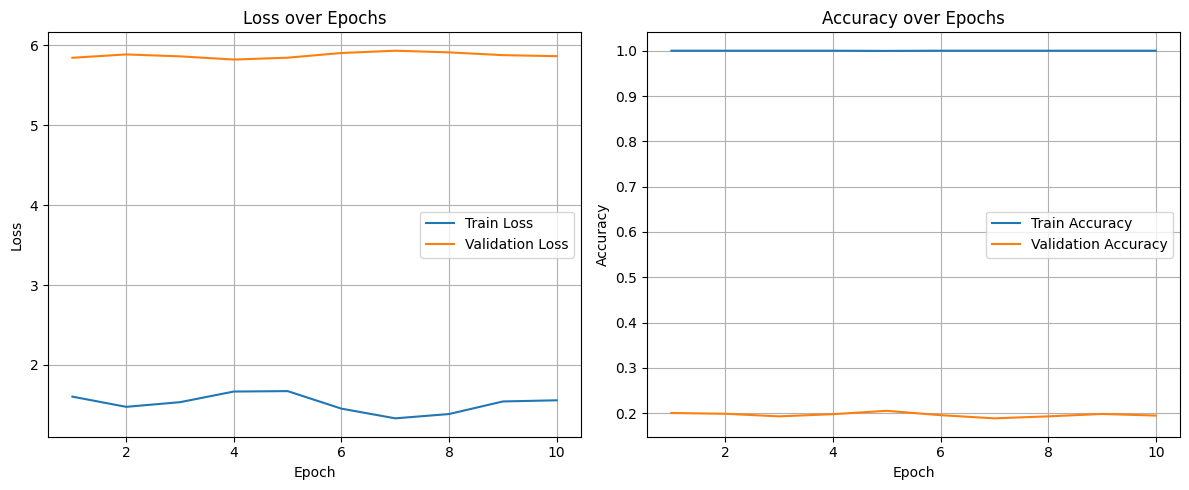

In [24]:
import matplotlib.pyplot as plt

# Placeholder: assume train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s are collected
# Generate synthetic curves to demonstrate plotting logic

epochs = list(range(1, 11))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss curve
axes[0].plot(epochs, train_losses, label='Train Loss')
axes[0].plot(epochs, val_losses, label='Validation Loss')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy curve
axes[1].plot(epochs, train_accuracies, label='Train Accuracy')
axes[1].plot(epochs, val_accuracies, label='Validation Accuracy')
axes[1].set_title('Accuracy over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Evaluation Phase

In [19]:
def test_collate_fn(batch):
    """
    Custom collate function for test dataloader,
    allows category_id to be None.
    """
    images = torch.stack([item[0] for item in batch])
    labels = [item[1] for item in batch]  # will be all None
    file_paths = [item[2] for item in batch]
    observation_ids = [item[3] for item in batch]
    return images, labels, file_paths, observation_ids


In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=test_collate_fn
)

## Mean Pooling

In [21]:
def evaluate_protonet_grouped(model, dataloader, prototypes, device, dataset, k=10, save_path="test_predictions.csv"):
    """
    Evaluate using prototype similarity and group predictions by observation ID.
    Aggregates predictions per observation using mean pooling.


    Args:
        model: FungiEmbedder
        dataloader: test dataloader
        prototypes: tensor [num_classes, embedding_dim]
        device: cuda/cpu
        dataset: FungiTastic (for ID mapping)
        k: number of top predictions
        save_path: CSV save path
    """
    model.eval()
    observation_logits = {}

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            images, _, _, observation_ids = batch
            images = images.to(device)
            embeddings = model(images)
            dists = torch.cdist(embeddings, prototypes, p=2)  # [B, C]
            probs = -dists  # higher is better

            probs = probs.cpu().numpy()
            for i, obs_id in enumerate(observation_ids):
                if obs_id not in observation_logits:
                    observation_logits[obs_id] = []
                observation_logits[obs_id].append(probs[i])

    # Aggregate per observation
    results = []
    for obs_id, logits_list in observation_logits.items():
        avg_logits = np.mean(logits_list, axis=0)
        topk = np.argsort(avg_logits)[-k:][::-1]
        predictions = ' '.join(str(c) for c in topk)
        results.append({'ObservationId': obs_id, 'predictions': predictions})

    df = pd.DataFrame(results)
    df.to_csv(save_path, index=False)
    print(f"Saved grouped prediction results to {save_path}")
    return df


In [22]:
evaluate_protonet_grouped(
    model=embedder,
    dataloader=test_loader,
    prototypes=prototypes,
    device=config.device,
    dataset=test_dataset,
    k=config.top_k,
    save_path="results/test_predictions_protoNet_grouped.csv"
)


Evaluating: 100%|██████████| 60/60 [00:15<00:00,  3.97it/s]


Saved grouped prediction results to results/test_predictions_protoNet_grouped.csv


,ObservationId,predictions
0,4100099350,1695 10 2041 1438 1496 578 663 640 138 1276
1,4100096393,62 671 2028 2383 663 2119 578 672 318 859
2,4100103428,1278 16 19 13 15 1850 1277 735 1288 736
3,4100096438,946 224 1646 1059 259 2267 947 1422 1261 40
4,4100102708,929 928 726 1693 613 2288 1696 1398 2119 672
...,...,...
994,4465903547,1339 795 1627 112 2299 1768 910 1020 1469 245
995,4465903708,2136 651 650 877 2204 875 1955 885 1093 1766
996,4465903714,618 1566 1849 627 1120 19 1128 1850 450 1540
997,4465903823,2119 1491 672 29 675 615 1693 589 622 671


## Max Pooling

In [30]:
def evaluate_protonet_maxpool(model, dataloader, prototypes, device, dataset, k=10, save_path="test_predictions.csv"):
    """
    Evaluate using prototype similarity and group predictions by observation ID.
    Aggregates predictions per observation using max pooling.
    """
    model.eval()
    observation_logits = {}

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            images, _, _, observation_ids = batch
            images = images.to(device)
            embeddings = model(images)
            dists = torch.cdist(embeddings, prototypes, p=2)
            probs = -dists  # higher is better
            probs = probs.cpu().numpy()

            for i, obs_id in enumerate(observation_ids):
                if obs_id not in observation_logits:
                    observation_logits[obs_id] = []
                observation_logits[obs_id].append(probs[i])

    results = []
    for obs_id, logits_list in observation_logits.items():
        max_logits = np.max(logits_list, axis=0)  # max-pooling across images
        topk = np.argsort(max_logits)[-k:][::-1]
        predictions = ' '.join(str(c) for c in topk)
        results.append({'ObservationId': obs_id, 'predictions': predictions})

    df = pd.DataFrame(results)
    df.to_csv(save_path, index=False)
    print(f"Saved max-pooled prediction results to {save_path}")
    return df

In [31]:
evaluate_protonet_maxpool(embedder, test_loader, prototypes, config.device, test_dataset, k=config.top_k, save_path="results/test_predictions_protoNet_maxpool.csv")

Evaluating: 100%|██████████| 60/60 [00:23<00:00,  2.57it/s]


Saved max-pooled prediction results to results/test_predictions_protoNet_maxpool.csv


,ObservationId,predictions
0,4100099350,2041 2272 1418 138 1797 1393 2120 10 1438 613
1,4100096393,2028 2119 62 2383 671 859 578 663 672 1637
2,4100103428,15 1278 737 16 1850 735 398 1388 1288 1579
3,4100096438,224 946 1059 259 947 2267 1646 253 1422 40
4,4100102708,928 929 1696 1693 1264 382 1398 660 2175 613
...,...,...
994,4465903547,1339 1627 245 795 2299 900 877 1469 910 203
995,4465903708,651 2136 877 875 1203 1095 1093 2204 1339 1020
996,4465903714,618 617 1048 1566 1194 1540 627 365 1044 1446
997,4465903823,2119 672 1491 726 1300 1649 671 589 242 675


## Voting

In [32]:
from collections import Counter

def evaluate_protonet_voting(model, dataloader, prototypes, device, dataset, k=10, save_path="test_predictions_voting.csv"):
    """
    Evaluate model with voting-based aggregation across multiple images per observation.
    
    Args:
        model: trained embedder
        dataloader: test dataloader
        prototypes: class prototype embeddings
        device: torch.device
        dataset: FungiTastic dataset (for Observation IDs)
        k: number of top classes to return
        save_path: CSV file to write predictions
    """
    model.eval()
    observation_votes = {}

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating (Voting)"):
            images, _, _, observation_ids = batch
            images = images.to(device)
            embeddings = model(images)
            dists = torch.cdist(embeddings, prototypes, p=2)  # [B, C]
            logits = -dists
            preds = torch.topk(logits, k=k, dim=1).indices.cpu().numpy()  # [B, k]

            for i, obs_id in enumerate(observation_ids):
                if obs_id not in observation_votes:
                    observation_votes[obs_id] = []
                observation_votes[obs_id].extend(preds[i].tolist())

    # Aggregate by majority voting
    results = []
    for obs_id, votes in observation_votes.items():
        vote_count = Counter(votes)
        topk = [cls_id for cls_id, _ in vote_count.most_common(k)]
        # pad if not enough classes
        if len(topk) < k:
            topk += [topk[-1]] * (k - len(topk))
        prediction_str = ' '.join(str(c) for c in topk)
        results.append({'ObservationId': obs_id, 'predictions': prediction_str})

    df = pd.DataFrame(results)
    df.to_csv(save_path, index=False)
    print(f"Saved voting-based predictions to {save_path}")
    return df


In [33]:
evaluate_protonet_voting(
    model=embedder,
    dataloader=test_loader,
    prototypes=prototypes,
    device=config.device,
    dataset=test_dataset,
    k=config.top_k,
    save_path="results/test_predictions_protoNet_voting.csv"
)


Evaluating (Voting): 100%|██████████| 60/60 [00:19<00:00,  3.01it/s]

Saved voting-based predictions to results/test_predictions_protoNet_voting.csv


,ObservationId,predictions
0,4100099350,2041 2272 1418 138 1797 1393 2120 10 1438 613
1,4100096393,2028 2119 62 2383 671 859 578 663 672 1637
2,4100103428,15 1278 1281 737 961 1388 13 1288 1386 1277
3,4100096438,224 946 1059 259 947 2267 1646 253 1422 40
4,4100102708,928 929 1696 1693 1264 382 1398 660 2175 613
...,...,...
994,4465903547,1339 1627 245 795 2299 900 877 1469 910 203
995,4465903708,651 2136 877 875 1203 1095 1093 2204 1339 1020
996,4465903714,618 617 1048 1566 1194 1540 627 365 1044 1446
997,4465903823,2119 1491 726 672 1300 671 589 675 613 660
